#  Finding Synchrony/Mimicry in Motion Energy 


## Processing

In [1]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from mpl_toolkits.mplot3d import Axes3D
from dtw import dtw, accelerated_dtw
from mpl_toolkits import mplot3d
from scipy import signal
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import math
import json
import csv
import os

## Import CSVs as Dataframes

In [7]:
# RAW DATA
raw_data = pd.read_csv(r'\data\motion_energy_original_data.csv')
residuals_raw_data_P1 = pd.read_csv(r'\data\residuals_raw_data_P1.csv')
residuals_raw_data_P2 = pd.read_csv(r'\data\residuals_raw_data_P2.csv')

Text(0.5, 0.98, 'Motion energy data for person 1 and 2')

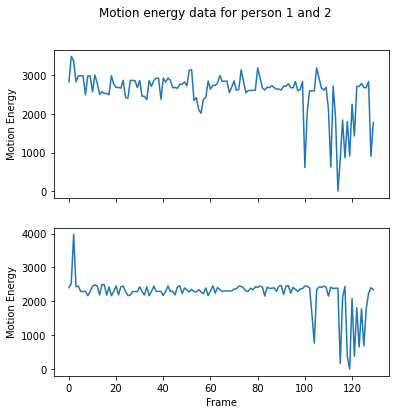

In [32]:
f,ax=plt.subplots(2,1,figsize=(6,6),sharex=True)
raw_data['motion_energy_first_person'][0:130].plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Motion Energy')

raw_data['motion_energy_second_person'][0:130].plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Motion Energy')

plt.suptitle("Motion energy data for person 1 and 2")

## Time Lagged Cross Correlation — assessing signal dynamics

In [14]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

<ipython-input-23-0f4603a3c724>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item - 90) for item in ax.get_xticks()]) # 175


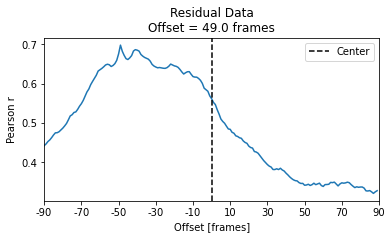

In [23]:
d1 = raw_data['motion_energy_first_person']
d2 = raw_data['motion_energy_second_person']

#d1 = residuals_raw_data_P1['0']
#d2 = residuals_raw_data_P2['0']

seconds = 3  #5
fps = 30   #58
rs = [crosscorr(d1, d2, lag) for lag in range(-int(seconds * fps - 1), int(seconds * fps+1))]
offset = np.ceil(len(rs) / 2) - np.argmax(rs)
f, ax = plt.subplots(figsize=(6, 3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs) / 2), color='k', linestyle='--', label='Center')
#ax.axvline(np.argmax(rs), color='r', linestyle='--', label='Peak synchrony')
ax.set(title=f'Residual Data\nOffset = {offset} frames', xlim=[0, 180], xlabel='Offset [frames]',ylabel='Pearson r') # 350
ax.set_xticklabels([int(item - 90) for item in ax.get_xticks()]) # 175
plt.legend()
plt.show()

## Windowed time lagged cross correlation

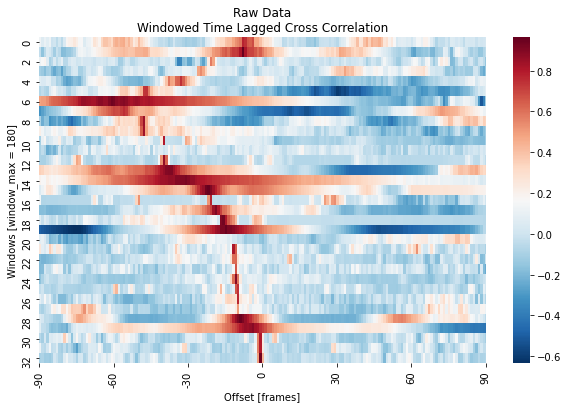

In [33]:
# Window epochs are 30. Each epoch has ~ 200 frames -> ~ 6 seconds
seconds = 3
fps = 30
no_splits = 33 
samples_per_split = residuals_raw_data_P1['0'].shape[0]/no_splits
rss=[]
offset = []
ccorr = []
mean = []
std = []
for t in range(0, no_splits):
    
    d1 = raw_data['motion_energy_first_person'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = raw_data['motion_energy_second_person'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    
    #d1 = residuals_raw_data_P1['0'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    #d2 = residuals_raw_data_P2['0'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    offset.append(np.ceil(len(rs) / 2) - np.argmax(rs))
    ccorr.append(np.argmax(rs))
    mean.append(np.mean(rs))
    std.append(np.std(rs))
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,6))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Raw Data\nWindowed Time Lagged Cross Correlation',xlim=[0,180], xlabel='Offset [frames]',ylabel='Windows [window_max = 180]')
ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_xticklabels([ -90, -60, -30, 0, 30, 60, 90]);

In [25]:
np.mean(std)

0.20474251670488258

In [26]:
mean_corr = 0
for i in range(0, len(rss)):
    mean_corr += rss.iloc[i].max()
print(mean_corr/len(rss))

0.7860508200253603


## Rolling window time lagged cross correlation

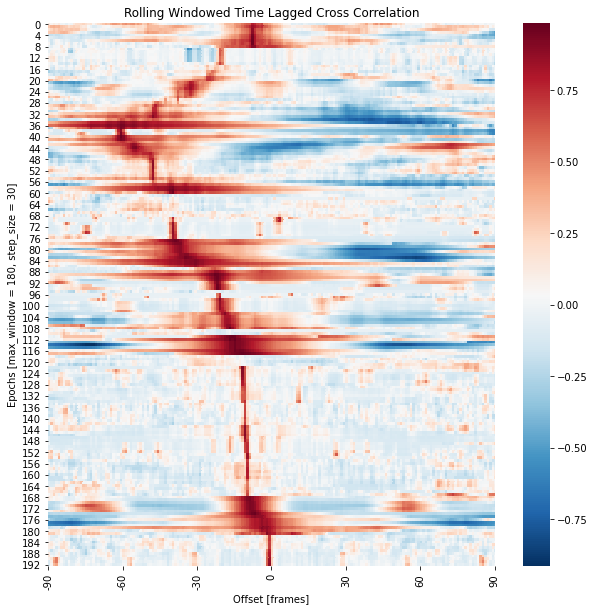

In [27]:
seconds = 3
fps = 30 # 58
window_size = 180 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
offset = []
std = []
ccorr = []
while t_end < len(residual_P1['0']):
    
    d1 = raw_data['motion_energy_first_person'].iloc[t_start:t_end]
    d2 = raw_data['motion_energy_second_person'].iloc[t_start:t_end]
    
    #d1 = residuals_raw_data_P1['0'].iloc[t_start:t_end]
    #d2 = residuals_raw_data_P2['0'].iloc[t_start:t_end]
    
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    rss.append(rs)
    offset.append(np.ceil(len(rs) / 2) - np.argmax(rs))
    std.append(np.std(rs))
    ccorr.append(np.argmax(rs))
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,180], xlabel='Offset [frames]',ylabel='Epochs [max_window = 180, step_size = 30]') # 350
ax.set_xticks([0, 30, 60, 90, 120, 150, 180])
ax.set_xticklabels([ -90, -60, -30, 0, 30, 60, 90]);

In [28]:
np.mean(std)

0.21401326301355328

In [29]:
mean_corr = 0
for i in range(0, len(rss)):
    mean_corr += rss.iloc[i].max()
print(mean_corr/len(rss))

0.7743334156566642


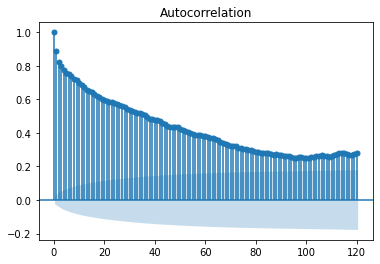

In [34]:
plot_acf(raw_data['motion_energy_first_person'], lags=120)
plt.show()

## Convergent Cross Mapping

In [30]:
import numpy as np
import metrics
import pyinform
from ctypes import byref, c_int, c_ulong, c_double, POINTER
from pyinform import _inform
from pyinform.error import ErrorCode, error_guard
print(pyinform.mutualinfo.mutual_info(raw_data['motion_energy_first_person'], raw_data['motion_energy_second_person'], local=False))

3.960892245343609


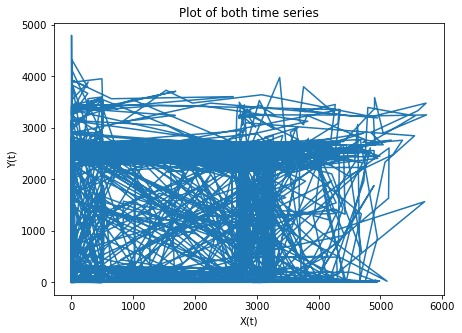

In [7]:
plt.figure(figsize=(7,5))
plt.plot(raw_data['motion_energy_first_person'], raw_data['motion_energy_second_person'])
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.title('Plot of both time series')
plt.show()


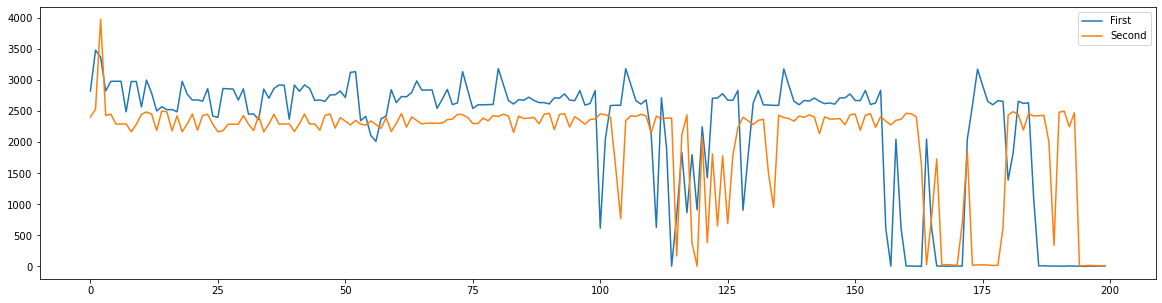

In [21]:
plt.figure(figsize=(20,5))
plt.plot(raw_data['motion_energy_first_person'][0:200], label="First") 
plt.plot(raw_data['motion_energy_second_person'][0:200], label="Second")
plt.legend()
plt.show()

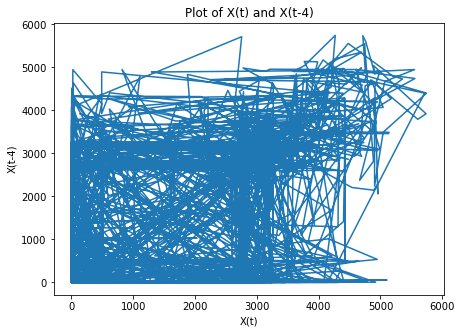

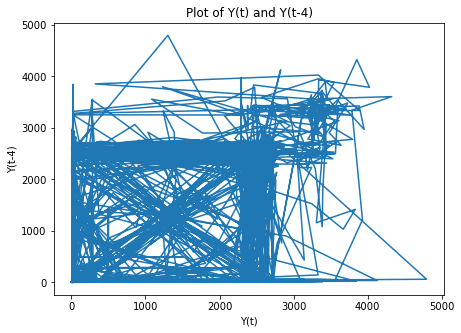

In [16]:
import skccm as ccm
import skccm.data as data
rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.2 #Influence of x1 on x2
b21 = 0.01 #Influence of x2 on x1
ts_length = 1000
#x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)
x1,x2 =  raw_data['motion_energy_first_person'], raw_data['motion_energy_second_person']

lag = 4  
embed = 2  
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)

X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)
df1 = pd.DataFrame(X1)
df2  = pd.DataFrame(X2)

plt.figure(figsize=(7,5))
plt.plot(df1[1], df1[0])
plt.xlabel('X(t)')
plt.ylabel('X(t-4)')
plt.title('Plot of X(t) and X(t-4)')
plt.show()
plt.figure(figsize=(7,5))
plt.plot(df2[1], df2[0])
plt.xlabel('Y(t)')
plt.ylabel('Y(t-4)')
plt.title('Plot of Y(t) and Y(t-4)')
plt.show()

2394


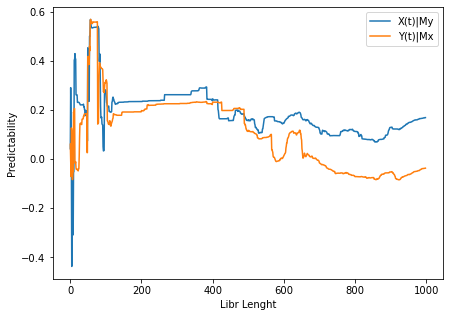

In [17]:
from skccm.utilities import train_test_split
#split the embedded time series
x1tr, x1te, x2tr, x2te = train_test_split(X1,X2, percent=.4)
CCM = ccm.CCM()
#initiate the class#library lengths to test
len_tr = len(x1tr)
print(len_tr)
#lib_lens = np.arange(10, len_tr, len_tr/4000, dtype='int')
lib_lens = np.arange(3, len_tr, len_tr/1000, dtype='int')

#test causation
CCM.fit(x1tr,x2tr)
x1p, x2p = CCM.predict(x1te, x2te,lib_lengths=lib_lens)
sc1,sc2 = CCM.score()

plt.figure(figsize=(7,5))
plt.plot(sc1, label = 'X(t)|My')
plt.plot(sc2, label = 'Y(t)|Mx')
plt.legend()
plt.xlabel('Libr Lenght')
plt.ylabel('Predictability')
plt.show()

## Sarogate Test

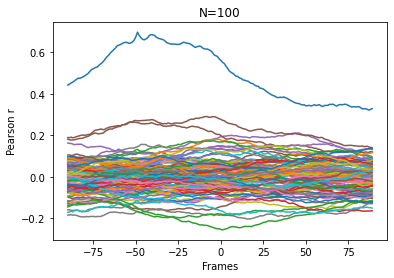

In [18]:
from random import randrange
import skccm as ccm
import skccm.data as data

#x1,x2 =  raw_data['motion_energy_first_person'], raw_data['motion_energy_second_person']
lag = 180  #4
embed = 33  # 49
e1 = ccm.Embed(x1)
e2 = ccm.Embed(x2)

X1 = e1.embed_vectors_1d(lag,embed)
X2 = e2.embed_vectors_1d(lag,embed)
df1 = pd.DataFrame(X1)
df2  = pd.DataFrame(X2)

rss = []
seconds = 3  #5
fps = 30   #58
d1 = raw_data['motion_energy_first_person']
d2 = raw_data['motion_energy_second_person']

rs = [crosscorr(d1, d2, lag) for lag in range(-int(seconds * fps - 1), int(seconds * fps+1))]
rss.append(rs)
for k in range(0,100):
    rand1 = []
    while (len(rand1) != 33):
        x = randrange(33)
        if not x in rand1:
            rand1.append(x)

    rand2 = []
    while (len(rand2) != 33):
        y = randrange(33)
        if not y in rand2:
            rand2.append(y)

    d1 = []
    d2 = []
    for i in range(1, len(rand1)):
        d1.extend(df1[rand1[i]].tolist())
        d2.extend(df2[rand2[i]].tolist())
    d1 = pd.DataFrame(d1)
    d2 = pd.DataFrame(d2)

    rs = [crosscorr(d1[0], d2[0], lag) for lag in range(-int(seconds * fps - 1), int(seconds * fps+1))]
    rss.append(rs)
    
    
z = []
for w in range(-90, 90):
    z.append(w) 
for i in range(0, len(rss)):
    plt.plot(z, rss[i], label = "line "+str(i))
plt.title('N=100')
plt.xlabel('Frames')
plt.ylabel('Pearson r')
plt.show()